# Lab Exercise 6: FSK-MSK

The purpose of this lab exercise is to simulate and analyze Frequency Shift Keying (FSK) and Minimum Shift Keying (MSK) systems. Students will compare coherent and non-coherent demodulation, calculate bit error rates, and examine the spectral properties of these modulation schemes. The exercise also includes an optional task to compare MSK and QPSK systems in terms of bit error rate and bandwidth.


## Setup


```{admonition} Live Code
Press the following button to make python code interactive. It will connect you to a kernel once it says "ready" (might take a bit, especially the first time it runs).
```

<div style="text-align: center;">
  <button title="Launch thebe" class="thebelab-button thebe-launch-button" onclick="initThebe()">Python Interactive Code</button>
</div>


#### Importing packages we will need later in Python


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.signal
from scipy.signal import welch
import scipy.special
from scipy.special import erfc
import math
from math import log, log2, sqrt
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, interactive, Layout, Dropdown, IntText, HBox, VBox, Output
from IPython.display import display, clear_output
from sk_dsp_comm.sigsys import cpx_awgn
import time
print("Libraries added successfully!")

Libraries added successfully!


## Part 1:

Run code 6.1 of the notes (step-by-step, not by calling the function) for M=16 and
confirm the obtained number of errors for two different values of the normalized
signal-to-noise ratio


`````{dropdown} Code 6.1
````{tab} Python
```python
def fsk_errors(bps, Nsymb, ns, EbNo):
    """
    Input parameters
    bps: bits per symbol, Nsymb: number of simulated symbols
    ns: number of samples per symbol (oversampling)
    EbNo: normalized signal-to-noise ratio, in dB
    """
    M = 2 ** bps  # number of different symbols
    BR = 1  # Baud Rate
    fc = 2 * M * BR  # RF frequency

    # Derived parameters
    nb = bps * Nsymb  # number of simulated data bits
    T = 1 / BR  # one symbol period
    Ts = T / ns  # oversampling period

    # M frequencies in "coherent" distance (BR)
    f = fc + BR / 2 * ((np.arange(1, M + 1)) - (M + 1) / 2)

    # AWGN channel
    SNR = EbNo + 10 * np.log10(bps) - 10 * np.log10(ns / 2)  # in dB

    # Input data bits
    y = np.floor(2 * np.random.rand(nb, 1)).astype(int)
    x = y.reshape(-1, bps)

    t = np.arange(0, len(x) * T, T)  # time vector on the T grid
    tks = np.arange(0, T, Ts)

    # FSK signal
    s = []
    A = np.sqrt(2 / T / ns)

    for k in range(len(x)):
        fk = f[int(''.join(map(str, x[k])), 2)]
        tk = (k - 1) * T + tks
        s.append(np.sin(2 * np.pi * fk * tk))

    s = np.concatenate(s)

    # Add noise to the FSK (passband) signal
    s = awgn(s, SNR, 'measured')

    # FSK receiver
    # Coherent demodulation
    xr = []

    for k in range(len(s) // ns):
        tk = (k - 1) * T + tks
        sk = s[(k - 1) * ns:k * ns]
        smi = []

        for i in range(M):
            si = np.sin(2 * np.pi * f[i] * tk)
            smi.append(np.sum(sk * si))

        j = np.argmax(smi)
        xr.append(np.binary_repr(j, bps))

    xr = np.array([list(map(int, xr[i])) for i in range(len(xr))])

    # Count errors
    err = x != xr
    errors = np.sum(err)

    return errors
```
````

````{tab} Matlab
```matlab
function errors = fsk_errors(bps, Nsymb, ns, EbNo)
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    %% Input parameters
    % bps: bits per symbol, Nsymb: numb of simulated symbols
    % ns: number of samples per symbol (oversampling)
    % EbNo: normalized signal-to-noise ratio, in db
    M = 2^bps; % number of different symbols
    BR = 1; % Baud Rate
    fc = 2 * M * BR; % RF frequency
    %% Derived parameters
    nb = bps * Nsymb; % number of simulated data bits
    T = 1 / BR; % one symbol period
    Ts = T / ns; % oversampling period
    % M frequencies in "coherent" distance (BR)
    f = fc + BR / 2 * ((1:M) - (M + 1) / 2);
    % awgn channel
    SNR = EbNo + 10 * log10(bps) - 10 * log10(ns / 2); % in db
    % input data bits
    y = floor(2*rand(nb, 1)); %
    x = reshape(y, bps, length(y) / bps)';
    t = [0:T:length(x(:, 1)) * T]'; % time vector on the T grid
    tks = [0:Ts:T - Ts]';
    %% FSK signal
    s = [];
    A = sqrt(2 / T / ns);

    for k = 1:length(x(:, 1))
        fk = f(bi2de(x(k, :)) + 1);
        tk = (k - 1) * T + tks;
        s = [s; sin(2 * pi * fk * tk)];
    end

    % add noise to the FSK (passband) signal
    s = awgn(s, SNR, 'measured');
    %% FSK receiver
    % coherent demodulation
    th = 0;
    xr = [];

    for k = 1:length(s) / ns
        tk = (k - 1) * T + tks;
        sk = s((k - 1) * ns + 1:k * ns);
        smi = [];

        for i = 1:M
            si = sin(2 * pi * f(i) * tk);
            smi(i) = sum(sk .* si);
        end

        [m, j] = max(smi);
        xr = [xr; de2bi(j - 1, bps)];
    end

    % count errors
    err = not(x == xr);
    errors = sum(sum(err));
end
```
````
`````


## Part 2:

Complete the above code in order to also simulate the non-coherent FSK

```{tip}
Add random phase to the received signal, before demodulation.
```


`````{dropdown} Code 6.2
````{tab} Python
```python
def fsk_errors(bps, Nsymb, ns, EbNo, mode):
    """
    Input parameters
    bps: bits per symbol
    Nsymb: number of simulated symbols
    ns: number of samples per symbol (oversampling)
    EbNo: normalized signal-to-noise ratio, in dB
    mode: 'coherent' or 'non-coherent'
    """
    M = 2 ** bps  # number of different symbols
    BR = 1  # Baud Rate
    fc = 2 * M * BR  # RF frequency

    # Derived parameters
    nb = bps * Nsymb  # number of simulated data bits
    T = 1 / BR  # one symbol period
    Ts = T / ns  # oversampling period

    if mode == 'coherent':
        # M frequencies in "coherent" distance (BR)
        f = fc + BR / 2 * (np.arange(1, M + 1) - (M + 1) / 2)
    else:
        # M frequencies in "non-coherent" distance (BR)
        f = fc + BR * (np.arange(1, M + 1) - (M + 1) / 2)

    # AWGN channel
    SNR = EbNo + 10 * np.log10(bps) - 10 * np.log10(ns / 2)  # in dB

    # Input data bits
    y = np.floor(2 * np.random.rand(nb, 1)).astype(int)
    x = y.reshape((-1, bps))

    t = np.arange(0, len(x) * T, T)  # time vector on the T grid
    tks = np.arange(0, T, Ts)

    # FSK signal
    s = []
    A = np.sqrt(2 / T / ns)

    for k in range(len(x)):
        fk = f[int(''.join(map(str, x[k])), 2)]
        tk = (k - 1) * T + tks
        s.append(np.sin(2 * np.pi * fk * tk))

    s = np.concatenate(s)

    # Add noise to the FSK (passband) signal
    s = cpx_awgn(s, SNR, ns)

    # FSK receiver
    xr = []

    for k in range(len(s) // ns):
        tk = (k - 1) * T + tks
        sk = s[(k - 1) * ns:k * ns]
        smi = []

        if mode == 'coherent':
            # Coherent demodulation
            for i in range(M):
                si = np.sin(2 * np.pi * f[i] * tk)
                smi.append(np.sum(sk * si))
        else:
            # Non-coherent demodulation
            th = np.random.rand()
            sm = np.zeros(M)
            for i in range(M):
                si = np.sin(2 * np.pi * (f[i] * tk + th))
                sq = np.cos(2 * np.pi * (f[i] * tk + th))
                smi = np.sum(sk * si)
                smq = np.sum(sk * sq)
                sm[i] = np.sqrt(smi**2 + smq**2)
            smi = sm

        j = np.argmax(smi)
        xr.append(list(map(int, np.binary_repr(j, bps))))

    xr = np.array(xr)

    # Count errors
    err = x != xr
    errors = np.sum(err)

    return errors
```
````

````{tab} Matlab
```matlab
function errors = fsk_errors(bps, Nsymb, ns, EbNo, mode)
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    %% Input parameters
    % bps: bits per symbol, Nsymb: number of simulated symbols
    % ns: number of samples per symbol (oversampling)
    % EbNo: normalized signal-to-noise ratio, in dB
    % mode: 'coherent' or 'non-coherent'
    M = 2^bps; % number of different symbols
    BR = 1; % Baud Rate
    fc = 2 * M * BR; % RF frequency

    %% Derived parameters
    nb = bps * Nsymb; % number of simulated data bits
    T = 1 / BR; % one symbol period
    Ts = T / ns; % oversampling period

    if strcmp(mode, 'coherent')
        % M frequencies in "coherent" distance (BR)
        f = fc + BR / 2 * ((1:M) - (M + 1) / 2);
    else
        % M frequencies in "non-coherent" distance (BR)
        f = fc + BR * ((1:M) - (M + 1) / 2);
    end

    % AWGN channel
    SNR = EbNo + 10 * log10(bps) - 10 * log10(ns / 2); % in dB

    % Input data bits
    y = floor(2 * rand(nb, 1));
    x = reshape(y, bps, length(y) / bps)';

    t = [0:T:length(x(:, 1)) * T]'; % time vector on the T grid
    tks = [0:Ts:T - Ts]';

    %% FSK signal
    s = [];
    A = sqrt(2 / T / ns);

    for k = 1:length(x(:, 1))
        fk = f(bi2de(x(k, :)) + 1);
        tk = (k - 1) * T + tks;
        s = [s; sin(2 * pi * fk * tk)];
    end

    % Add noise to the FSK (passband) signal
    s = awgn(s, SNR, 'measured');

    %% FSK receiver
    xr = [];

    for k = 1:length(s) / ns
        tk = (k - 1) * T + tks;
        sk = s((k - 1) * ns + 1:k * ns);
        smi = [];

        if strcmp(mode, 'coherent')
            % Coherent demodulation
            for i = 1:M
                si = sin(2 * pi * f(i) * tk);
                smi(i) = sum(sk .* si);
            end
        else
            % Non-coherent demodulation
            th = rand();
            sm = zeros(1, M);
            for i = 1:M
                si = sin(2 * pi * (f(i) * tk + th));
                sq = cos(2 * pi * (f(i) * tk + th));
                smi = sum(sk .* si);
                smq = sum(sk .* sq);
                sm(i) = sqrt(smi^2 + smq^2);
            end
            smi = sm;
        end

        [~, j] = max(smi);
        xr = [xr; de2bi(j - 1, bps)];
    end

    % Count errors
    err = not(x == xr);
    errors = sum(sum(err));
end
```
````
`````


## Part 3:

Use your new function to simulate a 16-FSK system and plot the Pb vs Eb/No curves
for coherent and non-coherent demodulation (theoretical and from simulation).


C:\Users\Sotiris\AppData\Local\Temp\ipykernel_8892\178654123.py:160: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  axs.legend();fig.show()


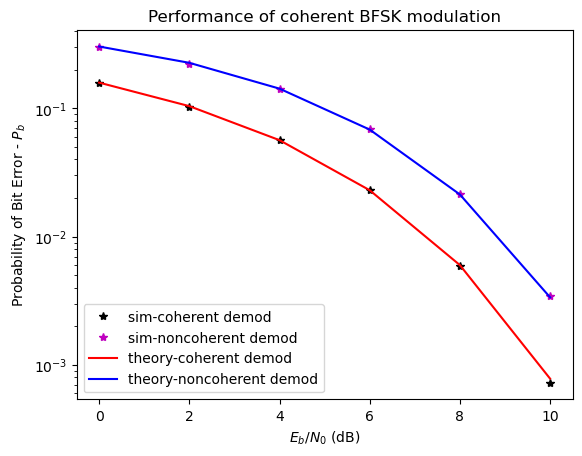

In [2]:
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
from scipy.special import erfc

def bfsk_mod(a,fc,fd,L,fs,fsk_type='coherent',enable_plot = False):
	"""
	Function to modulate an incoming binary stream using BFSK
	Parameters:
	a : input binary data stream (0's and 1's) to modulate
	fc : center frequency of the carrier in Hertz
	fd : frequency separation measured from Fc
	L : number of samples in 1-bit period
	fs : Sampling frequency for discrete-time simulation
	fsk_type : 'coherent' (default) or 'noncoherent' FSK generation
	enable_plot: True = plot transmitter waveforms (default False)
	Returns:
	(s_t,phase) : tuple containing following parameters
	s_t : BFSK modulated signal
	phase : initial phase generated by modulator, applicable only for
	,! coherent FSK. It can be used when using coherent detection at Rx
	"""
	from scipy.signal import upfirdn
	a_t = upfirdn(h=[1]*L, x=a, up = L) #data to waveform
	t = np.arange(start=0,stop=len(a_t))/fs #time base
	if fsk_type.lower() == 'noncoherent':
		# carrier 1 with random phase
		c1 = np.cos(2*np.pi*(fc+fd/2)*t+2*np.pi*np.random.random_sample())
		# carrier 2 with random phase
		c2 = np.cos(2*np.pi*(fc-fd/2)*t+2*np.pi*np.random.random_sample())
	else: #coherent is default
		# random phase from uniform distribution [0,2pi)
		phase=2*np.pi*np.random.random_sample()
		c1 = np.cos(2*np.pi*(fc+fd/2)*t+phase) # carrier 1 with random phase
		c2 = np.cos(2*np.pi*(fc-fd/2)*t+phase) # carrier 2 with the same random phase
	s_t = a_t*c1 +(-a_t+1)*c2 # BFSK signal (MUX selection)
	if enable_plot:
		fig, (ax1,ax2)=plt.subplots(2, 1);ax1.plot(t,a_t);ax2.plot(t,s_t);fig.show()
	return (s_t,phase)

def bfsk_coherent_demod(r_t,phase,fc,fd,L,fs):
	"""
	Coherent demodulation of BFSK modulated signal
	Parameters:
	r_t : BFSK modulated signal at the receiver r(t)
	phase : initial phase generated at the transmitter
	fc : center frequency of the carrier in Hertz
	fd : frequency separation measured from Fc
	L : number of samples in 1-bit period
	fs : Sampling frequency for discrete-time simulation
	Returns:
	a_hat : data bits after demodulation
	"""
	t = np.arange(start=0,stop=len(r_t))/fs # time base
	x = r_t*(np.cos(2*np.pi*(fc+fd/2)*t+phase)-np.cos(2*np.pi*(fc-fd/2)*t+phase))
	y = np.convolve(x,np.ones(L)) # integrate/sum from 0 to L
	a_hat = (y[L-1::L]>0).astype(int) # sample at every sampling instant and detect
	return a_hat

def bfsk_noncoherent_demod(r_t,fc,fd,L,fs):
	"""
	Non-coherent demodulation of BFSK modulated signal
	Parameters:
	r_t : BFSK modulated signal at the receiver r(t)
	fc : center frequency of the carrier in Hertz
	fd : frequency separation measured from Fc
	L : number of samples in 1-bit period
	fs : Sampling frequency for discrete-time simulation
	Returns:
	a_hat : data bits after demodulation
	"""
	t = np.arange(start=0,stop=len(r_t))/fs # time base
	f1 = (fc+fd/2); f2 = (fc-fd/2)
	#define four basis functions
	p1c = np.cos(2*np.pi*f1*t); p2c = np.cos(2*np.pi*f2*t)
	p1s = -1*np.sin(2*np.pi*f1*t); p2s = -1*np.sin(2*np.pi*f2*t)
	# multiply and integrate from 0 to L
	r1c = np.convolve(r_t*p1c,np.ones(L)); r2c = np.convolve(r_t*p2c,np.ones(L))
	r1s = np.convolve(r_t*p1s,np.ones(L)); r2s = np.convolve(r_t*p2s,np.ones(L))
	# sample at every sampling instant
	r1c = r1c[L-1::L]; r2c = r2c[L-1::L]
	r1s = r1s[L-1::L]; r2s = r2s[L-1::L]
	# square and add
	x = r1c**2 + r1s**2
	y = r2c**2 + r2s**2
	a_hat=((x-y)>0).astype(int) # compare and decide
	return a_hat


def awgn(s,SNRdB,L=1):
	"""
	AWGN channel
	Add AWGN noise to input signal. The function adds AWGN noise vector to signal
	's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
	returns the noise vector 'n' that is added to the signal 's' and the power
	spectral density N0 of noise added
	Parameters:
	s : input/transmitted signal vector
	SNRdB : desired signal to noise ratio (expressed in dB)
	for the received signal
	L : oversampling factor (applicable for waveform simulation)
	default L = 1.
	Returns:
	r : received signal vector (r=s+n)
	"""
	gamma = 10**(SNRdB/10) #SNR to linear scale
	if s.ndim==1:# if s is single dimensional vector
		P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
	else: # multi-dimensional signals like MFSK
		P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
	N0=P/gamma # Find the noise spectral density
	if isrealobj(s):# check if input is real/complex object type
		n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
	else:
		n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
	r = s + n # received signal
	return r


N=100000 # Number of bits to transmit
EbN0dB = np.arange(start=0,stop = 11, step = 2) # Eb/N0 range in dB for simulation
fc = 400 # center carrier frequency f_c- integral multiple of 1/Tb
fsk_type = 'coherent' # coherent/noncoherent FSK generation at Tx
h = 1 # modulation index
# h should be minimum 0.5 for coherent FSK or multiples of 0.5
# h should be minimum 1 for non-coherent FSK or multiples of 1
L = 40 # oversampling factor
fs = 8*fc # sampling frequency for discrete-time simulation
fd = h/(L/fs) # Frequency separation
BER_coherent = np.zeros(len(EbN0dB)) # BER for coherent BFSK
BER_noncoherent = np.zeros(len(EbN0dB)) # BER for non-coherent BFSK
a = np.random.randint(2, size=N) # uniform random symbols from 0's and 1's
[s_t,phase]=bfsk_mod(a,fc,fd,L,fs,fsk_type) # BFSK modulation
for i, EbN0 in enumerate(EbN0dB):
	r_t = awgn(s_t,EbN0,L) # refer Chapter section 4.1
	if fsk_type.lower() == 'coherent':
		# coherent FSK could be demodulated coherently or non-coherently
		a_hat_coherent = bfsk_coherent_demod(r_t,phase,fc,fd,L,fs) # coherent demod
		a_hat_noncoherent = bfsk_noncoherent_demod(r_t,fc,fd,L,fs)#noncoherent demod
		BER_coherent[i] = np.sum(a!=a_hat_coherent)/N # BER for coherent case
		BER_noncoherent[i] = np.sum(a!=a_hat_noncoherent)/N # BER for non-coherent
	if fsk_type.lower() == 'noncoherent':
		#non-coherent FSK can only non-coherently demodulated
		a_hat_noncoherent = bfsk_noncoherent_demod(r_t,fc,fd,L,fs)#noncoherent demod
		BER_noncoherent[i] = np.sum(a!=a_hat_noncoherent)/N # BER for non-coherent
#Theoretical BERs
theory_coherent = 0.5*erfc(np.sqrt(10**(EbN0dB/10)/2)) # Theory BER - coherent
theory_noncoherent = 0.5*np.exp(-10**(EbN0dB/10)/2) # Theory BER - non-coherent
fig, axs = plt.subplots(1, 1)
if fsk_type.lower() == 'coherent':
	axs.semilogy(EbN0dB,BER_coherent,'k*',label='sim-coherent demod')
	axs.semilogy(EbN0dB,BER_noncoherent,'m*',label='sim-noncoherent demod')
	axs.semilogy(EbN0dB,theory_coherent,'r-',label='theory-coherent demod')
	axs.semilogy(EbN0dB,theory_noncoherent,'b-',label='theory-noncoherent demod')
	axs.set_title('Performance of coherent BFSK modulation')
if fsk_type.lower() == 'noncoherent':
	axs.semilogy(EbN0dB,BER_noncoherent,'m*',label='sim-noncoherent demod')
	axs.semilogy(EbN0dB,theory_noncoherent,'b-',label='theory-noncoherent demod')
	axs.set_title('Performance of noncoherent BFSK modulation')
axs.set_xlabel('$E_b/N_0$ (dB)');axs.set_ylabel('Probability of Bit Error - $P_b$')
axs.legend();fig.show()





In [3]:
a = [1,2,3,4,5,6]
print(a[0:5])

[1, 2, 3, 4, 5]


18563


18149


17771


17573


17405


17362
[0.464075, 0.453725, 0.444275, 0.439325, 0.435125, 0.43405]


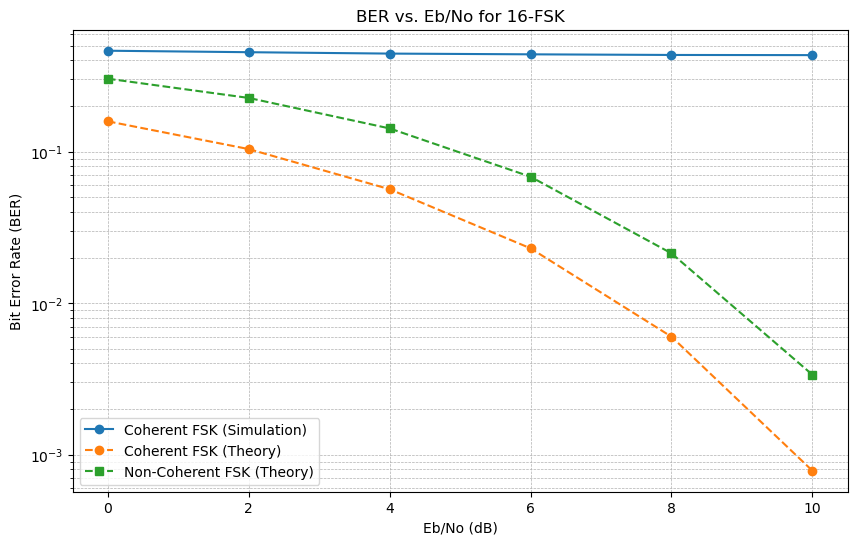

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.special import erfc
from sk_dsp_comm.sigsys import cpx_awgn



def fsk_errors(bps, Nsymb, ns, EbNo):
    """
    Input parameters
    bps: bits per symbol, Nsymb: number of simulated symbols
    ns: number of samples per symbol (oversampling)
    EbNo: normalized signal-to-noise ratio, in dB
    """
    M = 2 ** bps  # number of different symbols
    BR = 1  # Baud Rate
    fc = 2 * M * BR  # RF frequency

    # Derived parameters
    nb = bps * Nsymb  # number of simulated data bits
    T = 1 / BR  # one symbol period
    Ts = T / ns  # oversampling period

    # M frequencies in "coherent" distance (BR)
    f = fc + BR / 2 * ((np.arange(1, M + 1)) - (M + 1) / 2)

    # AWGN channel
    SNR = EbNo + 10 * np.log10(bps) - 10 * np.log10(ns / 2)  # in dB

    # Input data bits
    y = np.floor(2 * np.random.rand(nb, 1)).astype(int)
    x = y.reshape(-1, bps)

    t = np.arange(0, len(x) * T, T)  # time vector on the T grid
    tks = np.arange(0, T, Ts)

    # FSK signal
    s = []
    A = np.sqrt(2 / T / ns)

    for k in range(len(x)):
        fk = f[int(''.join(map(str, x[k])), 2)]
        tk = (k - 1) * T + tks
        s.append(np.sin(2 * np.pi * fk * tk))

    s = np.concatenate(s)

    # Add noise to the FSK (passband) signal
    s = awgn(s, SNR)

    # FSK receiver
    # Coherent demodulation
    xr = []

    for k in range(1,(len(s) // ns)+1):
        tk = (k - 1) * T + tks
        sk = s[(k - 1) * ns:k * ns]
        smi = []

        for i in range(M):
            si = np.sin(2 * np.pi * f[i] * tk)
            smi.append(np.sum(sk * si))

        j = np.argmax(smi)
        xr.append(np.binary_repr(j, bps))

    xr = np.array([list(map(int, xr[i])) for i in range(len(xr))])

    # Count errors
    err = x != xr
    errors = np.sum(err)

    return errors

def theoretical_ber_coherent(M, EbNo):
    return 0.5 * erfc(np.sqrt(10 ** (EbNo / 10) / 2))

def theoretical_ber_non_coherent(M, EbNo):
    return 0.5 * np.exp(-10 ** (EbNo / 10) / 2)

# Simulation parameters
bps = 4  # for 16-FSK
Nsymb = 10000  # Number of symbols to be simulated
nsamp = 80
EbNo_dB_range = np.arange(0, 12, 2)  # Reduced number of points

ber_coherent_sim = []
ber_non_coherent_sim = []
ber_coherent_theory = []
ber_non_coherent_theory = []

for EbNo_dB in EbNo_dB_range:
    errors_coherent = fsk_errors(bps, Nsymb, nsamp, EbNo_dB)
    """ errors_non_coherent = fsk_errors(bps, Nsymb, nsamp, EbNo_dB) """
    
    print(errors_coherent)
    ber_coherent_sim.append(errors_coherent / (Nsymb * bps))
    """ ber_non_coherent_sim.append(errors_non_coherent / (Nsymb * bps)) """
    
    ber_coherent_theory.append(theoretical_ber_coherent(16, EbNo_dB))
    ber_non_coherent_theory.append(theoretical_ber_non_coherent(16, EbNo_dB))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.semilogy(EbNo_dB_range, ber_coherent_sim, 'o-', label='Coherent FSK (Simulation)')
""" plt.semilogy(EbNo_dB_range, ber_non_coherent_sim, 's-', label='Non-Coherent FSK (Simulation)') """
plt.semilogy(EbNo_dB_range, ber_coherent_theory, 'o--', label='Coherent FSK (Theory)')
plt.semilogy(EbNo_dB_range, ber_non_coherent_theory, 's--', label='Non-Coherent FSK (Theory)')
print(ber_coherent_sim)
plt.xlabel('Eb/No (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs. Eb/No for 16-FSK')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


## Part 4:

Plot the spectrum of the bandpass signal of question 3.


In [5]:
Ts = 1 / nsamp  # oversampling period
Fs = 1 / Ts  # sampling frequency

# Plotting the spectrum of the bandpass signal
f_coherent, Pxx_coherent = welch(s_coherent.flatten(), Fs, nperseg=1024)
f_non_coherent, Pxx_non_coherent = welch(s_non_coherent.flatten(), Fs, nperseg=1024)

plt.figure(figsize=(10, 6))
plt.semilogy(f_coherent, Pxx_coherent, label='Coherent FSK Spectrum')
plt.semilogy(f_non_coherent, Pxx_non_coherent, label='Non-Coherent FSK Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V^2/Hz)')
plt.title('Power Spectral Density of the Bandpass Signal')
plt.grid(True)
plt.legend()
plt.show()

NameError: name 's_coherent' is not defined

## Part 5

```{note}
Optional. Bonus 10% to Lab grade
```


### Step 1:

Based on Code 6.2 of the notes, simulate an MSK transmission system on a
bandpass channel with a center frequency of 8 MHz and a transmission rate
of 2 Mbps. Plot the spectrum of the bandpass signal and calculate
(theoretically and by simulation) the BER, when Eb/No=10db.


### Step 2:

For the data of the previous question, find the values of the parameters of an
equivalent (in terms of bit rate) QPSK system. Compare the two systems in
terms of BER and bandwidth.

```{tip}
According to the figure below, for each odd k, the new bi (valid from the
next even k) and bq are calculated. Based on these, the two new bits are calculated,
xr(k)=bi_1*bq and xr(k+1)=bi*bq. With precoding, bit xr_1 of the previous period (k-1) is
also used.
```

![lab6_1.png](../content/images/lab6_1.png)
